<a href="https://colab.research.google.com/github/sunnysinghnitb/Higgs-Boson-Machine-Learning-Challenge/blob/master/Higgs_Boson_Machine_Learning_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#%cd ..
#%cd ./root

!mkdir .kaggle
%cd ./.kaggle

from google.colab import files
up = files.upload()

/root/.kaggle


Saving kaggle.json to kaggle.json


In [0]:
#!chmod 600 /root/.kaggle/kaggle.json
#!kaggle competitions download -c higgs-boson
#!unzip training.zip
!unzip test.zip
!ls

Archive:  test.zip
  inflating: test.csv                
HiggsBosonCompetition_AMSMetric_rev1.py  test.csv      training.zip
kaggle.json				 test.zip
random_submission.zip			 training.csv


In [0]:
#importing necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import Imputer, StandardScaler
import math
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
%matplotlib inline
train = pd.read_csv('training.csv')
train.head()

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,DER_pt_ratio_lep_tau,DER_met_phi_centrality,DER_lep_eta_centrality,PRI_tau_pt,PRI_tau_eta,PRI_tau_phi,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_met,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label
0,100000,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,41.928,197.760,1.582,1.396,0.2,32.638,1.017,0.381,51.626,2.273,-2.414,16.824,-0.277,258.733,2,67.435,2.150,0.444,46.062,1.24,-2.475,113.497,0.002653,s
1,100001,160.937,68.768,103.235,48.146,-999.00,-999.000,-999.000,3.473,2.078,125.157,0.879,1.414,-999.0,42.014,2.039,-3.011,36.918,0.501,0.103,44.704,-1.916,164.546,1,46.226,0.725,1.158,-999.000,-999.00,-999.000,46.226,2.233584,b
2,100002,-999.000,162.172,125.953,35.635,-999.00,-999.000,-999.000,3.148,9.336,197.814,3.776,1.414,-999.0,32.154,-0.705,-2.093,121.409,-0.953,1.052,54.283,-2.186,260.414,1,44.251,2.053,-2.028,-999.000,-999.00,-999.000,44.251,2.347389,b
3,100003,143.905,81.417,80.943,0.414,-999.00,-999.000,-999.000,3.310,0.414,75.968,2.354,-1.285,-999.0,22.647,-1.655,0.010,53.321,-0.522,-3.100,31.082,0.060,86.062,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,-0.000,5.446378,b
4,100004,175.864,16.915,134.805,16.405,-999.00,-999.000,-999.000,3.891,16.405,57.983,1.056,-1.385,-999.0,28.209,-2.197,-2.231,29.774,0.798,1.569,2.723,-0.871,53.131,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000,6.245333,b


In [0]:
del(train['EventId'])
y = train['Label']
Weight = train['Weight']
del(train['Label'])
del(train['Weight'])
X = train

In [0]:
train.head()

,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,DER_pt_ratio_lep_tau,DER_met_phi_centrality,DER_lep_eta_centrality,PRI_tau_pt,PRI_tau_eta,PRI_tau_phi,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_met,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt
0,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,41.928,197.760,1.582,1.396,0.2,32.638,1.017,0.381,51.626,2.273,-2.414,16.824,-0.277,258.733,2,67.435,2.150,0.444,46.062,1.24,-2.475,113.497
1,160.937,68.768,103.235,48.146,-999.00,-999.000,-999.000,3.473,2.078,125.157,0.879,1.414,-999.0,42.014,2.039,-3.011,36.918,0.501,0.103,44.704,-1.916,164.546,1,46.226,0.725,1.158,-999.000,-999.00,-999.000,46.226
2,-999.000,162.172,125.953,35.635,-999.00,-999.000,-999.000,3.148,9.336,197.814,3.776,1.414,-999.0,32.154,-0.705,-2.093,121.409,-0.953,1.052,54.283,-2.186,260.414,1,44.251,2.053,-2.028,-999.000,-999.00,-999.000,44.251
3,143.905,81.417,80.943,0.414,-999.00,-999.000,-999.000,3.310,0.414,75.968,2.354,-1.285,-999.0,22.647,-1.655,0.010,53.321,-0.522,-3.100,31.082,0.060,86.062,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,-0.000
4,175.864,16.915,134.805,16.405,-999.00,-999.000,-999.000,3.891,16.405,57.983,1.056,-1.385,-999.0,28.209,-2.197,-2.231,29.774,0.798,1.569,2.723,-0.871,53.131,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000


In [0]:
imp = Imputer(missing_values=-999.00, strategy='median')
cols = X.columns
X = pd.DataFrame(imp.fit_transform(X), columns=cols)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


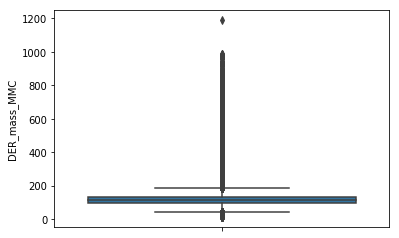

In [0]:
sns.boxplot(y = X['DER_mass_MMC'])

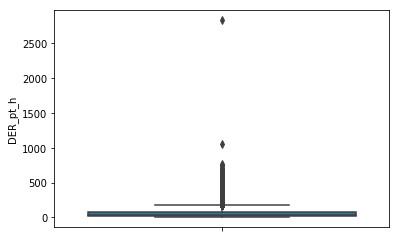

In [0]:
sns.boxplot(y = X['DER_pt_h'])

In [0]:
X.describe(percentiles=[0.9999])

,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,DER_pt_ratio_lep_tau,DER_met_phi_centrality,DER_lep_eta_centrality,PRI_tau_pt,PRI_tau_eta,PRI_tau_phi,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_met,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt
count,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000
mean,120.417434,49.239819,81.181982,57.895962,2.193104,268.220619,-0.411629,2.373100,18.917332,158.432217,1.437609,-0.128305,0.455245,38.707419,-0.010973,-0.008171,46.660207,-0.019507,0.043543,41.717235,-0.010119,209.797178,0.979176,77.124366,-0.001966,-0.020629,50.739149,-0.010535,-0.001879,73.064591
std,52.859218,35.344886,40.828691,63.655682,0.948104,224.229668,1.948520,0.782911,22.273494,115.706115,0.844743,1.193585,0.214768,22.412081,1.214079,1.816763,22.064922,1.264982,1.816611,32.894693,1.812223,126.499506,0.977426,47.939899,1.382703,1.405084,17.792135,1.094446,0.978743,98.015662
min,9.044000,0.000000,6.329000,0.000000,0.000000,13.602000,-18.066000,0.208000,0.000000,46.104000,0.047000,-1.414000,0.000000,20.000000,-2.499000,-3.142000,26.000000,-2.505000,-3.142000,0.109000,-3.142000,13.678000,0.000000,30.000000,-4.499000,-3.142000,30.000000,-4.500000,-3.142000,0.000000
50%,112.406000,46.524000,73.752000,38.467500,2.107000,225.885000,-0.244000,2.491500,12.315500,120.664500,1.280000,-0.356000,0.454000,31.804000,-0.023000,-0.033000,40.516000,-0.045000,0.086000,34.802000,-0.024000,179.739000,1.000000,65.561000,0.000000,-0.033000,47.902000,-0.010000,-0.002000,40.512500
99.99%,889.698197,418.616078,664.854606,596.067187,7.930000,3333.822071,13.767001,5.398000,273.422242,1245.433069,12.255004,1.414000,1.000000,349.588210,2.484000,3.141000,335.588391,2.480000,3.141000,415.625062,3.141000,1315.289070,3.000000,617.356068,4.464000,3.140000,384.815048,4.463000,3.139000,1098.724034
max,1192.026000,690.075000,1349.351000,2834.999000,8.503000,4974.979000,16.690000,5.684000,2834.999000,1852.462000,19.773000,1.414000,1.000000,764.408000,2.497000,3.142000,560.271000,2.503000,3.142000,2842.617000,3.142000,2003.976000,3.000000,1120.573000,4.499000,3.141000,721.456000,4.500000,3.142000,1633.433000


In [0]:
#Points above the 99.99 percentile are considered as outlier
col_cutoff = {'DER_mass_MMC' : 890, 'DER_mass_vis' : 665, 'DER_pt_h' : 597, 'DER_mass_jet_jet' : 3334, 'DER_pt_tot' : 274, 'DER_sum_pt' : 1246, 'PRI_tau_pt' : 350, 'PRI_lep_pt' : 336, 'PRI_met' : 416, 'PRI_met_sumet' : 1316, 'PRI_jet_leading_pt' : 618, 'PRI_jet_subleading_pt' :385,'PRI_jet_all_pt' : 1099}
for col, cutoff in col_cutoff.items():
    y = y[ X[col] <= cutoff]
    Weight = Weight[ X[col] <= cutoff ]
    X = X[ X[col] <= cutoff]

In [0]:
cols = X.columns
X = np.array(X)
log_cols = [0, 1, 2, 3, 5, 8, 9, 10, 12, 13, 16, 19, 21, 22, 23, 26, 29]
X[:, log_cols] = np.log(1 + X[:, log_cols])
X = pd.DataFrame(X, columns=cols)
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=cols)

In [0]:
def ams(s, b):
    return math.sqrt(2 * ((s + b + 10) * math.log(1.0 + s/(b + 10)) - s))
def get_ams_score(W, Y, Y_pred):
    s = np.sum(W * (Y == 1) * (Y_pred == 1))
    b = np.sum(W * (Y == 0) * (Y_pred == 1))
    return ams(s, b)

In [0]:
X = np.array(X)
y = np.array(y=='s', dtype=int)
Weight = np.array(Weight)
train_X = X[:220000 , :]
train_y = y[:220000]
train_Weight = Weight[:220000]
val_X = X[220000:, :]
val_y = y[220000:]
val_Weight = Weight[220000:]
print (train_X.shape) #(220000, 30)
print (train_y.shape) #(220000,)
print (train_Weight.shape) #(220000,)
print (val_X.shape) #(29789, 30)
print (val_y.shape) #(29789,)
print (val_Weight.shape) #(29789,)

(220000, 30)
(220000,)
(220000,)
(30000, 30)
(30000,)
(30000,)


In [0]:
def print_best_asm(val_y_pred):
    thresholds = np.arange(75,95)
    ams_scores = []
    for threshold in thresholds:
        limit = np.percentile(val_y_pred, threshold)
        val_y_thesholded = val_y_pred > limit
        score = get_ams_score(val_Weight, val_y, val_y_thesholded)
        ams_scores.append(score)
    print ("Best ams score of ",max(ams_scores)," at threshold of  ",thresholds[np.argmax(ams_scores)])
params = {
    'n_estimators' : [300, 400, 500],
    'max_features' : [20, 25, 30],
    'max_depth' : [10, 12, 15],
    'min_samples_split' : [50, 100, 150],
    'min_samples_leaf' : [50, 100, 150]
}
#etc = GridSearchCV(ExtraTreesClassifier(), params, verbose=True, n_jobs=-1)
#etc.fit(train_X, train_y, sample_weight=train_Weight)
#print etc.best_params_
etc = ExtraTreesClassifier(class_weight='balanced', n_estimators = 400, max_features = 30, max_depth = 15, min_samples_leaf = 100, min_samples_split = 100, n_jobs = -1)
etc.fit(train_X, train_y, sample_weight=train_Weight)
val_y_pred = etc.predict_proba(val_X)[:,1]
print_best_asm(val_y_pred)

Best ams score of  1.1331181526310279  at threshold of   82


In [0]:
#using a shallow MLP
mlp1 = MLPClassifier(hidden_layer_sizes=(50, 100, 50), early_stopping=True)
mlp1.fit(train_X, train_y)
val_y_pred = mlp1.predict_proba(val_X)[:,1]
print_best_asm(val_y_pred)

Best ams score of  1.1892908796135746  at threshold of   82


In [0]:
#using deeper MLP
mlp2 = MLPClassifier(hidden_layer_sizes=(50, 100, 200, 100, 50), early_stopping=True)
#mlp2.fit(train_X, train_y), early_stopping=True)
mlp2.fit(train_X, train_y)
val_y_pred = mlp2.predict_proba(val_X)[:,1]
print_best_asm(val_y_pred)

Best ams score of  1.1231485239225523  at threshold of   81


In [0]:
#using XGBoost
gbm = xgb.XGBClassifier(max_depth=5, n_estimators=400, learning_rate=0.1, n_jobs=-1)
gbm.fit(train_X, train_y)
val_y_pred = gbm.predict_proba(val_X)[:,1]
print_best_asm(val_y_pred)

Best ams score of  1.2172940781049  at threshold of   85


In [0]:
#using Soft voting classifier on shallow and deeper MLP
vc = VotingClassifier(estimators=[('mlp1', mlp1) , ('mlp2', mlp2)], voting='soft')
vc.fit(train_X, train_y)
val_y_pred = vc.predict_proba(val_X)[:,1]
print_best_asm(val_y_pred)

Best ams score of  1.2259010181439485  at threshold of   88


In [0]:
#using AdaBoost with Extra Trees as base estimators
ada_etc = AdaBoostClassifier(n_estimators=50, learning_rate=0.1, base_estimator=etc)
ada_etc.fit(train_X, train_y, sample_weight=train_Weight)
val_y_pred = ada_etc.predict_proba(val_X)[:,1]
print_best_asm(val_y_pred)

In [0]:
test_data = pd.read_csv('test.csv')
event_id = test_data['EventId']
del(test_data['EventId'])
test_X = imp.transform(test_data) #using the same imputer object
test_X = np.array(test_X)
log_cols = [0, 1, 2, 3, 5, 8, 9, 10, 12, 13, 16, 19, 21, 22, 23, 26, 29]
test_X[:, log_cols] = np.log(1 + test_X[:, log_cols])
test_X = scaler.transform(test_X) #using the same scaler object
ada_etc.fit(X, y) #train on complete data set
test_pred_prob = ada_etc.predict_proba(test_X)[:,1]
limit = np.percentile(test_pred_proba, 86)
test_pred = test_pred_proba > limit #test_pred contains one for #label 's' and 0 otherwise.